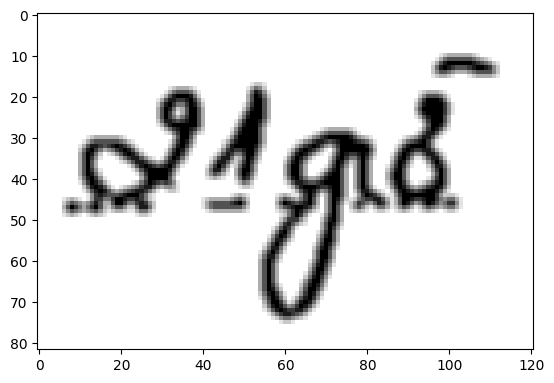

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image as pil
from PIL import Image
from pkg_resources import parse_version
if parse_version(pil.__version__)>=parse_version('10.0.0'):
    Image.ANTIALIAS=Image.LANCZOS

import warnings
warnings.filterwarnings("ignore")

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

def maximize_contrast(imgGrayscale):
	#Làm cho độ tương phản lớn nhất 
	height, width = imgGrayscale.shape[:2]
	
	imgTopHat = np.zeros((height, width, 1), np.uint8)
	imgBlackHat = np.zeros((height, width, 1), np.uint8)
	structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)) #tạo bộ lọc kernel
	
	imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement, iterations = 5) #nổi bật chi tiết sáng trong nền tối
	#cv2.imwrite("tophat.jpg",imgTopHat)
	imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement, iterations = 15) #Nổi bật chi tiết tối trong nền sáng
	#cv2.imwrite("blackhat.jpg",imgBlackHat)
	imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat) 
	imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

	#Kết quả cuối là ảnh đã tăng độ tương phản 
	return imgGrayscalePlusTopHatMinusBlackHat

def remove_noise(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = maximize_contrast(img)

    _, blackAndWhite = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((2,3),np.uint8)
    blackAndWhite = cv2.dilate(blackAndWhite, np.ones((2,3),np.uint8), iterations=1)
    blackAndWhite = cv2.erode(blackAndWhite, kernel, iterations=1)
    blackAndWhite = cv2.dilate(blackAndWhite, np.ones((2,3),np.uint8), iterations=1)
    blackAndWhite = cv2.erode(blackAndWhite, kernel, iterations=1)
    blackAndWhite = cv2.dilate(blackAndWhite, np.ones((1,2),np.uint8), iterations=1)

    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(blackAndWhite, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:, -1] #get CC_STAT_AREA component
    img2 = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if sizes[i] >= 19:   #filter small dotted regions
            img2[labels == i + 1] = 255

    res = cv2.bitwise_not(img2)
    kernel1 = np.ones((2,2),np.uint8)
    res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel1)

    res = cv2.GaussianBlur(res,(3,3),2)

    return res

img = cv2.imread('img3.png')
img = remove_noise(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

Số 100 TP.


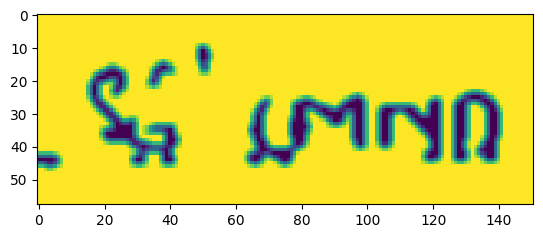

In [131]:
import cv2
import numpy as np
from PIL import Image as pil
from PIL import Image
from pkg_resources import parse_version
if parse_version(pil.__version__)>=parse_version('10.0.0'):
    Image.ANTIALIAS=Image.LANCZOS

import warnings
warnings.filterwarnings("ignore")

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

def maximize_contrast(imgGrayscale):
	#Làm cho độ tương phản lớn nhất 
	height, width = imgGrayscale.shape[:2]
	
	imgTopHat = np.zeros((height, width, 1), np.uint8)
	imgBlackHat = np.zeros((height, width, 1), np.uint8)
	structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)) #tạo bộ lọc kernel
	
	imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement, iterations = 5) #nổi bật chi tiết sáng trong nền tối
	#cv2.imwrite("tophat.jpg",imgTopHat)
	imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement, iterations = 15) #Nổi bật chi tiết tối trong nền sáng
	#cv2.imwrite("blackhat.jpg",imgBlackHat)
	imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat) 
	imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

	#Kết quả cuối là ảnh đã tăng độ tương phản 
	return imgGrayscalePlusTopHatMinusBlackHat

def remove_noise(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = maximize_contrast(img)

    _, blackAndWhite = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    blackAndWhite = cv2.dilate(blackAndWhite, np.ones((2,2),np.uint8), iterations=1)
    blackAndWhite = cv2.erode(blackAndWhite, np.ones((2,2),np.uint8), iterations=1)
    blackAndWhite = cv2.dilate(blackAndWhite, np.ones((1,2),np.uint8), iterations=1)

    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(blackAndWhite, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:, -1] #get CC_STAT_AREA component
    img2 = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if sizes[i] >= 19:   #filter small dotted regions
            img2[labels == i + 1] = 255

    res = cv2.bitwise_not(img2)
    kernel1 = np.ones((2,2),np.uint8)
    res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel1)

    res = cv2.GaussianBlur(res,(3,3),2)

    return res

class OCRModel(object):
    def __init__(self, weight_path=None):
        if weight_path != None:
            self.weight_path = weight_path
        else:
            self.weight_path = "vietocr_model/weights/vgg_transformer_default.pth"

        # self.config = Cfg.load_config_from_name('vgg_transformer')
        self.config = Cfg.load_config_from_file('vietocr_model/config.yml')
        self.config['weights'] = self.weight_path
        self.config['cnn']['pretrained']=False
        self.config['device'] = 'cpu'
        self.config['predictor'].update({'beamsearch': True})

        self.detector = Predictor(self.config)

    def recognize(self, img):
        s = self.detector.predict(Image.fromarray(img), return_prob=False)
        return s



ocr = OCRModel("vietocr_model/weights/transformerocr_custom.pth")
# ocr = OCRModel()
img = Image.open('img1.png')
img = remove_noise(np.array(img))
plt.imshow(img)
s = ocr.recognize(np.array(img))
print(s)
